In [3]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv

In [4]:
rheed_long = pd.read_csv("../data/onti_p.csv")
print(rheed_long.shape)
rheed_long[:1]

(2363772, 18)


,Unnamed: 0,Unnamed: 0.1,Coolness_RHEED,Length_RHEED,R FWHM_RHEED,Speed_RHEED,Time_RHEED,X FWHM_RHEED,Y FWHM_RHEED,Crystal Position,Displayed Rate,Filtered Rate,Fundamental Freq,Length,Raw Rate,Source Power,Speed,Time
0,0,0.0,0.0,0.003721,0.0,0.040601,2021-02-23 02:21:05,0.0,0.0,1.0,6.025618,5.999182,5.967367e+06,0.003721,5.987163,21.635099,NaN,2021-02-23 02:21:05


In [5]:
val_col = ['Coolness_RHEED',  'R FWHM_RHEED',  'X FWHM_RHEED', 'Y FWHM_RHEED',
        'Filtered Rate', 'Displayed Rate', 'Raw Rate',
       'Source Power']

def generated_dataset(series, wind_size=5):
    result = series.rolling(wind_size).agg(['mean', 'std', 'var'])
    delta = series - series.shift(wind_size)
    result = result.join(delta)
    result.rename(columns={c:str(c).replace('\'', '').replace('(', '').replace(')', '')
                             + "_" +str(wind_size) for c in result.columns}, inplace=True)

    return result

df_X = generated_dataset(rheed_long[val_col])
df_X.shape, df_X.columns

d:\projects\olimps\python\venv\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


((2363772, 32),
 Index(['Coolness_RHEED, mean_5', 'Coolness_RHEED, std_5',
        'Coolness_RHEED, var_5', 'R FWHM_RHEED, mean_5', 'R FWHM_RHEED, std_5',
        'R FWHM_RHEED, var_5', 'X FWHM_RHEED, mean_5', 'X FWHM_RHEED, std_5',
        'X FWHM_RHEED, var_5', 'Y FWHM_RHEED, mean_5', 'Y FWHM_RHEED, std_5',
        'Y FWHM_RHEED, var_5', 'Filtered Rate, mean_5', 'Filtered Rate, std_5',
        'Filtered Rate, var_5', 'Displayed Rate, mean_5',
        'Displayed Rate, std_5', 'Displayed Rate, var_5', 'Raw Rate, mean_5',
        'Raw Rate, std_5', 'Raw Rate, var_5', 'Source Power, mean_5',
        'Source Power, std_5', 'Source Power, var_5', 'Coolness_RHEED_5',
        'R FWHM_RHEED_5', 'X FWHM_RHEED_5', 'Y FWHM_RHEED_5', 'Filtered Rate_5',
        'Displayed Rate_5', 'Raw Rate_5', 'Source Power_5'],
       dtype='object'))

In [6]:
df_X = df_X.join(generated_dataset(rheed_long[val_col], wind_size=50))
df_X = df_X.join(generated_dataset(rheed_long[val_col], wind_size=435))
df_X = df_X.join(generated_dataset(rheed_long[val_col], wind_size=10000))
df_X.shape

(2363772, 128)

In [7]:
wind_size = 435

mask_base = df_X.isna().sum(axis=1)==0
df = df_X[wind_size:-wind_size]

cool_col = 'Coolness_RHEED, mean_50'
y = ((df[cool_col] - df[cool_col].shift(-wind_size)) > 5)
y.index

RangeIndex(start=435, stop=2363337, step=1)

In [9]:
index_list = random.sample([ i for i in y[(y==1)].index.tolist() if i > 10001],18000)
index_list += random.sample([ i for i in y[(y==0)].index.tolist() if i > 10001],25000)
df = df.loc[index_list]
y = y.loc[index_list]
mask = mask_base
df = df[mask]
y = y[mask]
categorical_features_indices = np.where(df.dtypes != np.float)[0]
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.1)
# x_train, y_train = df, y

<ipython-input-9-307cea6c95a3>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask]


In [10]:
model = CatBoostClassifier(
    # l2_leaf_reg=int(best['l2_leaf_reg']),
    # learning_rate=best['learning_rate'],
    # iterations=300,
    # eval_metric='AUC',
    random_seed=888,
    verbose=True,
    custom_loss=['AUC'],
    # loss_function='Logloss',
    #od_type='Iter',
    #od_wait=250
)
# Learning rate 0.035394

In [11]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
#validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

model.fit(train_pool)#, eval_set=validate_pool)

Learning rate set to 0.051336
0:	learn: 0.6671165	total: 205ms	remaining: 3m 24s
1:	learn: 0.6454212	total: 229ms	remaining: 1m 54s
2:	learn: 0.6223830	total: 254ms	remaining: 1m 24s
3:	learn: 0.6037952	total: 280ms	remaining: 1m 9s
4:	learn: 0.5874834	total: 306ms	remaining: 1m
5:	learn: 0.5723140	total: 331ms	remaining: 54.8s
6:	learn: 0.5587756	total: 356ms	remaining: 50.5s
7:	learn: 0.5444612	total: 384ms	remaining: 47.6s
8:	learn: 0.5330899	total: 413ms	remaining: 45.4s
9:	learn: 0.5218715	total: 437ms	remaining: 43.3s
10:	learn: 0.5116841	total: 462ms	remaining: 41.5s
11:	learn: 0.4976594	total: 487ms	remaining: 40.1s
12:	learn: 0.4887593	total: 512ms	remaining: 38.9s
13:	learn: 0.4803632	total: 536ms	remaining: 37.7s
14:	learn: 0.4731617	total: 560ms	remaining: 36.8s
15:	learn: 0.4625033	total: 584ms	remaining: 35.9s
16:	learn: 0.4572769	total: 608ms	remaining: 35.2s
17:	learn: 0.4509417	total: 632ms	remaining: 34.5s
18:	learn: 0.4447379	total: 658ms	remaining: 34s
19:	learn: 0.

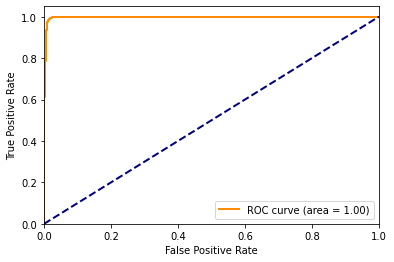

0.997712691324188

In [24]:
pred = model.predict_proba(x_test)[:,1]
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test, pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [12]:
import pickle
with open("../saves/cat/f1.pkl","wb") as f:
    pickle.dump(model, f)